In [1]:
# https://www.kaggle.com/kutaykutlu/resnet50-transfer-learning-cifar-10-beginner

# https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

In [2]:
from keras.applications.vgg16 import VGG16
from tensorflow import keras

In [3]:
model = VGG16(weights='imagenet')

In [4]:
import tensorflow as tf
import numpy as np
import pathlib

# step 1
# IMAGE_PATHS_DIR = r"C:\Users\na-ch\Desktop\estudio\Master_Big_Data\03_TFM\02_Code\dataset_test\CASIA_IrisV1_unif_segv2_edg_norm"
IMAGE_PATHS_DIR = r"C:\Users\na-ch\Desktop\estudio\Master_Big_Data\03_TFM\04_GitHub_Master\iris_classifier-master\notebooks\old\CASIA-IrisV1_unif_segv2_edg_norm"
paths = np.array([x.__str__() for x in pathlib.Path(IMAGE_PATHS_DIR).rglob('*.bmp')])
filenames = tf.constant(paths)

labels_array = np.array([x.split("\\")[-1].split("_")[0] for x in paths])
labels = tf.constant(labels_array)

n_clases = np.max([int(i) for i in labels_array])

# step 2: create a dataset returning slices of `filenames`
dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

def _parse_function(filename, label):
    img = tf.io.read_file(filename)
    image = tf.image.decode_bmp(img, channels = 3)
    label = tf.one_hot(int(label), n_clases) 
    return image, label

dataset_map = dataset.map(_parse_function)

dataset_map = dataset_map.shuffle(10)

dataset_len = len(dataset_map)

train_size = int(0.7 * dataset_len)
val_size = int(0.15 * dataset_len)
test_size = int(0.15 * dataset_len)

train_ds = dataset_map.take(train_size)
test_ds = dataset_map.skip(train_size)
validation_ds = test_ds.skip(val_size)
test_ds = test_ds.skip(test_size)

size = (224, 224)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)



In [5]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))

outputs = VGG16(include_top=True, weights=None, classes=n_clases)(inputs)
model = keras.Model(inputs, outputs)

model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

In [6]:
epochs = 5  # @param {type: "slider", min:10, max:100}
hist = model.fit(train_ds, epochs=epochs, validation_data=test_ds, verbose=2)

Epoch 1/5
25/25 - 539s - loss: 379.0430 - accuracy: 0.0000e+00 - val_loss: 4.4316 - val_accuracy: 0.0000e+00 - 539s/epoch - 22s/step
Epoch 2/5
25/25 - 464s - loss: 4.6875 - accuracy: 0.0139 - val_loss: 4.5640 - val_accuracy: 0.0000e+00 - 464s/epoch - 19s/step
Epoch 3/5
25/25 - 447s - loss: 4.8138 - accuracy: 0.0126 - val_loss: 4.7994 - val_accuracy: 0.0000e+00 - 447s/epoch - 18s/step
Epoch 4/5
25/25 - 465s - loss: 7.5439 - accuracy: 0.0240 - val_loss: 5.7555 - val_accuracy: 0.0000e+00 - 465s/epoch - 19s/step
Epoch 5/5
25/25 - 425s - loss: 4.5079 - accuracy: 0.0000e+00 - val_loss: 6.4842 - val_accuracy: 0.0000e+00 - 425s/epoch - 17s/step


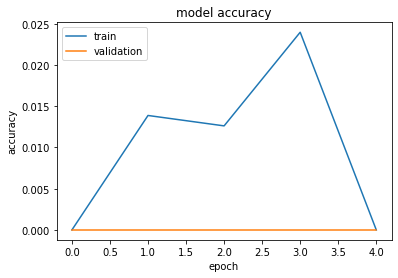

In [7]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [9]:
from tensorflow.keras import layers


def build_model(num_classes):
    inputs = layers.Input(shape=(224, 224, 3))
    x = img_augmentation(inputs)
    model = VGG16(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs)
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [10]:
model = build_model(num_classes=n_clases)

epochs = 10  # @param {type: "slider", min:8, max:80}
hist = model.fit(train_ds, epochs=epochs, validation_data=test_ds, verbose=2)

Epoch 1/10
25/25 - 124s - loss: 5.7574 - accuracy: 0.0088 - val_loss: 8.0798 - val_accuracy: 0.0000e+00 - 124s/epoch - 5s/step
Epoch 2/10
25/25 - 131s - loss: 1.9356 - accuracy: 0.5839 - val_loss: 7.6974 - val_accuracy: 0.0000e+00 - 131s/epoch - 5s/step
Epoch 3/10
25/25 - 149s - loss: 0.6085 - accuracy: 0.8852 - val_loss: 7.1111 - val_accuracy: 0.0000e+00 - 149s/epoch - 6s/step
Epoch 4/10
25/25 - 146s - loss: 0.2785 - accuracy: 0.9533 - val_loss: 7.2655 - val_accuracy: 0.0000e+00 - 146s/epoch - 6s/step
Epoch 5/10
25/25 - 149s - loss: 0.1336 - accuracy: 0.9874 - val_loss: 7.3463 - val_accuracy: 0.0000e+00 - 149s/epoch - 6s/step
Epoch 6/10
25/25 - 148s - loss: 0.0802 - accuracy: 0.9950 - val_loss: 7.6252 - val_accuracy: 0.0000e+00 - 148s/epoch - 6s/step
Epoch 7/10
25/25 - 154s - loss: 0.0522 - accuracy: 0.9962 - val_loss: 7.7045 - val_accuracy: 0.0000e+00 - 154s/epoch - 6s/step
Epoch 8/10
25/25 - 142s - loss: 0.0509 - accuracy: 0.9924 - val_loss: 7.9193 - val_accuracy: 0.0000e+00 - 142s/

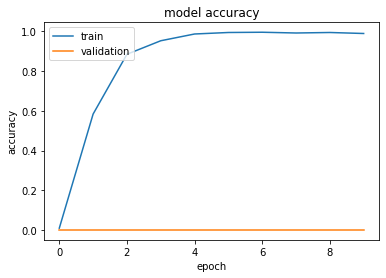

In [11]:
plot_hist(hist)

Epoch 1/5
25/25 - 342s - loss: 4.1096 - accuracy: 0.1728 - val_loss: 40.3018 - val_accuracy: 0.0000e+00 - 342s/epoch - 14s/step
Epoch 2/5
25/25 - 353s - loss: 4.0617 - accuracy: 0.1286 - val_loss: 48.1244 - val_accuracy: 0.0000e+00 - 353s/epoch - 14s/step
Epoch 3/5
25/25 - 387s - loss: 3.7071 - accuracy: 0.1311 - val_loss: 65.8712 - val_accuracy: 0.0000e+00 - 387s/epoch - 15s/step
Epoch 4/5
25/25 - 383s - loss: 3.2700 - accuracy: 0.1955 - val_loss: 20.4387 - val_accuracy: 0.0000e+00 - 383s/epoch - 15s/step
Epoch 5/5
25/25 - 362s - loss: 2.7529 - accuracy: 0.3077 - val_loss: 19.4718 - val_accuracy: 0.0000e+00 - 362s/epoch - 14s/step


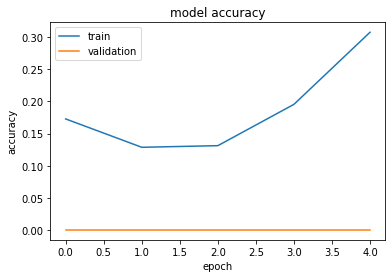

In [12]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 5  # @param {type: "slider", min:8, max:50}
hist = model.fit(train_ds, epochs=epochs, validation_data=test_ds, verbose=2)
plot_hist(hist)

In [27]:
size = (224, 224)

def _parse_image(filename):
    img = tf.io.read_file(filename)
    img = tf.image.decode_bmp(img, channels = 3)
    img = tf.image.resize(img, size)
    img = tf.expand_dims(img, 0)
    return img

# try_image_path =  r"C:\Users\na-ch\Desktop\estudio\Master_Big_Data\03_TFM\02_Code\dataset_test\CASIA_IrisV1_unif\001_1_1.bmp"
try_image_path =  r"C:\Users\na-ch\Desktop\estudio\Master_Big_Data\03_TFM\02_Code\dataset_test\CASIA_IrisV1_unif_segv2_edg_norm\002_2_2.bmp"

try_image = _parse_image(try_image_path)

In [28]:
result = model.predict(try_image)
np.argmax(result) +1

51

In [29]:
result

array([[6.15573703e-10, 1.98702432e-09, 6.27218166e-10, 1.90163335e-14,
        1.41374768e-11, 8.68747829e-09, 1.48272321e-14, 1.80494590e-13,
        3.09642394e-12, 3.36410726e-11, 3.10125528e-14, 3.88153641e-11,
        1.78161392e-11, 1.27595063e-15, 4.16929353e-08, 3.06502034e-06,
        6.72795932e-06, 7.07889910e-07, 2.65863692e-10, 1.49901012e-12,
        3.93422551e-11, 3.82887926e-08, 7.11832870e-10, 2.74245160e-09,
        4.35466333e-12, 2.82134334e-08, 2.62936256e-10, 7.55035953e-13,
        2.62459477e-12, 4.69211421e-13, 9.45845898e-07, 3.82121854e-08,
        9.44115012e-12, 1.62993952e-09, 6.63704647e-11, 1.52419879e-13,
        5.41684189e-12, 1.58811518e-16, 3.66329500e-09, 9.69707821e-12,
        4.22610252e-10, 1.01022401e-13, 2.74623267e-06, 2.45611773e-07,
        9.71988268e-10, 6.30156691e-08, 7.97359123e-11, 1.44520791e-05,
        4.04414245e-11, 4.35921654e-09, 9.99970555e-01, 1.85606912e-11,
        6.74371515e-14, 1.12176977e-07, 3.06350702e-13, 3.587046

In [16]:
# model.save('raw_complete')

In [17]:
model.save('normal_complete')

INFO:tensorflow:Assets written to: normal_complete\assets


In [18]:
# import tensorflow_datasets as tfds

# batch_size = 64

# dataset_name = "stanford_dogs"
# (ds_train, ds_test), ds_info = tfds.load(
#     dataset_name, split=["train", "test"], with_info=True, as_supervised=True
# )
# NUM_CLASSES = ds_info.features["label"].num_classes

In [19]:
# IMG_SIZE = 224

# size = (IMG_SIZE, IMG_SIZE)
# ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
# ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

In [20]:
# # One-hot / categorical encoding
# def input_preprocess(image, label):
#     label = tf.one_hot(label, NUM_CLASSES)
#     return image, label


# ds_train = ds_train.map(
#     input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
# )
# ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
# ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

# ds_test = ds_test.map(input_preprocess)
# ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)

In [21]:
# x = 0
# for i, a in ds_test:
#     if x < 1:
#         print(a.numpy()==1) 
#         print("-----")
#         x +=1
#     else:
#         break

In [22]:
# from tensorflow.keras.applications import EfficientNetB0
# from tensorflow.keras import layers


# inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
# outputs = EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)(inputs)

# model = tf.keras.Model(inputs, outputs)
# model.compile(
#         optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
#     )

# model.summary()

# epochs = 1  # @param {type: "slider", min:10, max:100}
# hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)